In [1]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import os

In [2]:
labels = ["Coleoptera", "Diptera", "Hemiptera", "Hymenoptera", "Lepidoptera", "Odonata"]


### Reading the tf record files

In [10]:
tf_records_path = os.path.join(os.getcwd(), "dataset/records")
tf_records = [os.path.join(tf_records_path, path) for path in os.listdir(tf_records_path)]
print(f"found {len(tf_records)} tf records files")

found 68 tf records files


In [13]:
image_feature_description = {
    "image/encoded" : tf.io.FixedLenFeature([], tf.string),
    "image/obj/heights": tf.io.VarLenFeature(tf.int64),
    "image/obj/widths": tf.io.VarLenFeature(tf.int64),
    "image/obj/lefts": tf.io.VarLenFeature(tf.int64),
    "image/obj/tops": tf.io.VarLenFeature(tf.int64),
    "image/obj/class_id": tf.io.VarLenFeature(tf.int64)
}



def parse_function(example_proto): 
    """
        deserialize a raw record
    """
    example =  tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.image.decode_image(example["image/encoded"], channels=3)

    image = tf.cast(image, dtype=tf.float32) / 255.0
    
    bboxes = tf.stack([
     tf.sparse.to_dense(example["image/obj/heights"]), 
     tf.sparse.to_dense(example["image/obj/widths"]), 
     tf.sparse.to_dense(example["image/obj/lefts"]), 
     tf.sparse.to_dense(example["image/obj/tops"])
    ], axis=1)
    
    # resizing all images
        
    label = tf.stack(tf.sparse.to_dense(example["image/obj/class_id"]))
    
    return image, bboxes, label
    

In [23]:
# opening the raw dataset out of the tf records files
raw_dataset = tf.data.TFRecordDataset(tf_records)


tf.Tensor([[0 0 0 0]], shape=(1, 4), dtype=int64)


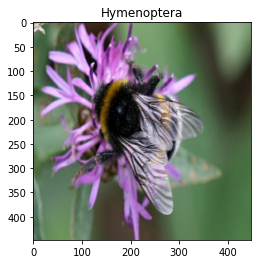

In [24]:
raw_dataset = raw_dataset.map(parse_function)
for sample in raw_dataset.take(1): 
    img = sample[0] 
    label = np.squeeze(sample[2])
    label = labels[label]
    print(sample[1])
    plt.title(label)
    plt.imshow(img)

### functions to manipulate bounding boxes 

In [25]:
def from_whlt_to_xyxy(bboxes): 
    """
        convert a bboxs with format whlt to xmin ymin xmax ymax format
        Input: 
            a (n,4) tensor
    """
    
    return tf.stack([
        bboxes[:,2], 
        bboxes[:,3], 
        bboxes[:,2] + bboxes[:,0],
        bboxes[:,3] + bboxes[:,1]
    ], axis=-1)

def from_xyxy_to_xywh(bboxes): 
    return tf.stack(
        [(boxes[:,0] + boxes[:, 2]) / 2,
        (boxes[:, 1] + boxes[:, 3]) / 2,
        boxes[:, 2] - boxes[:,0], 
        boxes[:, 3] - boxes[:, 1]], 
        axis=-1
    )

def from_xywh_to_xyxy(bboxes): 
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

In [26]:
def parse_bboxes(image, bboxes, label): 
    return image, from_whlt_to_xyxy(bboxes), label

dataset = raw_dataset.map(parse_bboxes)

In [22]:
dataset

<MapDataset shapes: (<unknown>, (4, None), (None,)), types: (tf.float32, tf.int64, tf.int64)>